In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [3]:
train_path_images = os.path.abspath("SaltID/train/images")
train_path_masks = os.path.abspath("SaltID/train/masks")
train_path_images
# images
# masks

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\train\\images'

In [4]:
test_path_images = os.path.abspath("SaltID/test/images")
test_path_masks = os.path.abspath("SaltID/test/masks")
test_path_images

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\test\\images'

In [5]:
train_path_images_list = glob(os.path.join(train_path_images, "**/*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "**/*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "**/*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "**/*.png"))

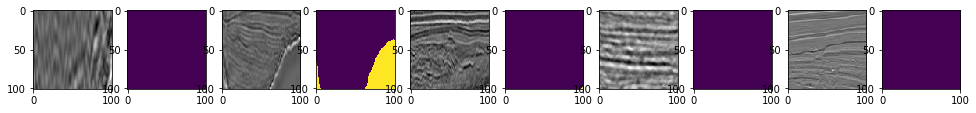

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [8]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [43]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        anti_aliasing=True,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [44]:
# Get and resize train images and masks
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
print('Getting and resizing test images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = imread(path_test + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


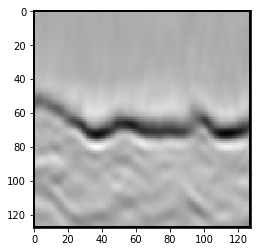

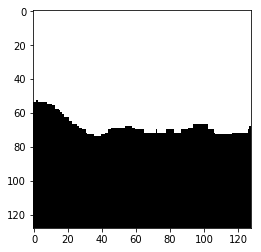

In [45]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

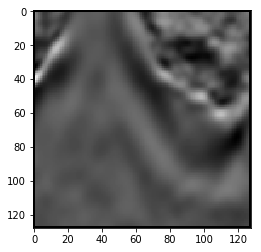

In [46]:
# Check if training data looks all right
ix = random.randint(0, len(test_ids))
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()

In [80]:
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [81]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [82]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

X_test_shaped = X_test.astype(np.float32)

In [83]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped, train=True, preprocessed_masks=Y_train_shaped)
salt_ID_dataset_test = saltIDDataset(X_test_shaped, train=False)

batch_size = 100
n_iters = 40
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [92]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

def double_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, 8, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(8, 16, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(16, 32, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(32, 64, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(64, 128, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(128, 64, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(128, 64, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(64, 32, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(64, 32, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(32, 16, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(16, 8, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(16, 8, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(8, 1, 1, 1, 0)
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        #print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        #print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        #print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        #print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        #print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        #print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        #print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        #print(one_by_one.size())
        
        return one_by_one

In [93]:
model = Unet()
model.cuda()

Unet(
  (double_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1,

In [94]:
criterion = nn.BCELoss()

In [95]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [98]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

In [100]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, masks)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        print(iter)
        
        if iter % 500 == 0:
            print("Hello")
            
#             # Calculate Accuracy         
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for images, masks in train_loader:
                
#                 images = Variable(images.cuda())
                
#                 # Forward pass only to get logits/output
#                 outputs = model(images)
                
#                 # Get predictions from the maximum value
#                 _, predicted = torch.max(outputs.data, 1)
                
#                 # Total number of labels
#                 total += labels.size(0)
                
#                 correct += (predicted.cpu() == labels.cpu()).sum()
                            
#             accuracy = 100 * correct / total
            
#             # Print Loss
#             print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [284]:
#nope

In [66]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        print("outputs", outputs[0])
        print("outputs", outputs.size())
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

Processing...
Done!
outputs tensor(1.00000e-02 *
       [-2.7577,  3.7014,  1.4376, -0.6427,  8.0197, -4.7681,  7.6578,
        -8.6932, -0.8391, -6.5978], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0232,  0.0359,  0.0029, -0.0698,  0.1069, -0.0491,  0.0539,
        -0.1394, -0.0755, -0.0444], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0430,  0.0699,  0.0118, -0.0467,  0.0532, -0.0718,  0.0498,
        -0.1688,  0.0458, -0.0401], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0097,  0.0833,  0.0435, -0.0386,  0.0928, -0.0429,  0.0353,
        -0.1634, -0.0343, -0.0830], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0014,  0.0544,  0.0501, -0.0278,  0.0685, -0.0572, -0.0097,
        -0.2116, -0.0488, -0.0469], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0218,  0.0708,  0.0569, -0.0973,  0.0555, -0.0639,  0.0797,
        -0.1488, -0.0329, -0.0588], device='cuda:0')
outputs torch.Siz

outputs tensor([ 0.0364,  0.0161,  0.0584,  0.0177,  0.0057, -0.0893, -0.0181,
        -0.2071,  0.0644, -0.1237], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0432,  0.0208,  0.0269,  0.0185,  0.0398, -0.0801,  0.0057,
        -0.2125,  0.0867, -0.0826], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0039,  0.0371, -0.0243,  0.0599, -0.0081, -0.0716,  0.0019,
        -0.1356,  0.0612, -0.0749], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0887, -0.0187, -0.0318,  0.0916, -0.0179, -0.0821,  0.0253,
        -0.1399,  0.0460, -0.0615], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0263,  0.0332,  0.0051, -0.0238,  0.0411, -0.0580,  0.0187,
        -0.1666,  0.0765, -0.0764], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0464, -0.0224,  0.0393, -0.0375,  0.0263, -0.0788,  0.0102,
        -0.1442,  0.0767, -0.0631], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0477, -0.

        -0.1749,  0.0701, -0.0605], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0270,  0.0154,  0.1490, -0.1373, -0.0439, -0.0811,  0.0428,
        -0.1075,  0.0383, -0.0603], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0151, -0.0205,  0.0483, -0.1408,  0.0814, -0.0912,  0.0394,
        -0.0356,  0.0608, -0.0308], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.1416,  0.1432,  0.0715, -0.0543,  0.0034, -0.1051,  0.0653,
        -0.0498, -0.0135, -0.0622], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0367,  0.0590,  0.1377, -0.1014, -0.0255, -0.1523,  0.0417,
        -0.1992,  0.0544, -0.0862], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0636, -0.0872,  0.0359,  0.0917, -0.0669, -0.0401,  0.0026,
        -0.1496,  0.0548,  0.0248], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0267, -0.0370,  0.0131, -0.0367, -0.0481, -0.1505, -0.0008,
         0.0877,  0.0126, -0

        -0.0706,  0.0830, -0.0915], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2295,  0.0860,  0.0894, -0.1098,  0.0269, -0.2634,  0.0077,
        -0.0002,  0.0710, -0.0563], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.1495,  0.0238,  0.3008,  0.0007, -0.1152, -0.1574,  0.1007,
        -0.0965,  0.1797, -0.2985], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2405,  0.0342, -0.1425,  0.0262,  0.0425, -0.1587, -0.0618,
         0.2604,  0.0720,  0.0416], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.3537,  0.4103,  0.0850, -0.0249, -0.1022, -0.2131,  0.0186,
         0.0061, -0.0368, -0.1250], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.1993, -0.0406,  0.3331, -0.0508,  0.0680, -0.2195,  0.1426,
        -0.1497,  0.1411, -0.0982], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.2028, -0.2826, -0.0013,  0.1929,  0.0465, -0.0656, -0.0441,
        -0.2882,  0.1082, -0

         0.0435,  0.2796,  0.0906], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.4449,  0.2698, -0.1714, -0.1838,  0.3158, -0.1645,  0.1823,
        -0.3067,  0.0319, -0.0503], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2992,  0.1679, -0.3798,  0.3424, -0.0179, -0.0225,  0.0786,
        -0.0208, -0.1239,  0.0180], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2070, -0.2258,  0.2404,  0.0747, -0.0679, -0.2531,  0.6915,
        -0.3195, -0.2298, -0.3860], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0614, -0.1479, -0.3112,  0.9189, -0.3931, -0.0206, -0.4051,
         0.0250, -0.1572,  0.0598], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.4993,  0.3368,  0.7457,  0.1928, -0.4782, -0.4677,  0.4433,
        -0.5415,  0.1268, -0.4801], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.8618,  0.2218, -0.2830,  0.1249, -0.1068, -0.4481, -0.4332,
         1.0738,  0.0026,  0

        -0.4326,  1.7377, -0.5056], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.9533, -2.4665, -0.6448,  0.9896, -0.8660,  1.2348,  0.1440,
         0.3039,  0.3131, -0.0805], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.3478,  0.3075, -1.0222,  0.2762, -0.8175,  0.4260, -0.2228,
         0.8468,  0.3083,  0.6292], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9550,  3.5177,  0.6958, -0.0948, -1.0668, -0.7846, -0.1704,
        -0.6125,  0.4972, -0.4083], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.0850, -0.9948,  2.3722, -1.0246,  1.3624, -1.1023,  1.0706,
        -1.3343,  0.5176, -0.4644], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.8877,  3.6707,  0.2475,  0.2328, -1.0906, -0.5221, -0.7799,
        -0.3550,  0.4099, -0.4502], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2479,  1.6395,  0.9258,  0.6809, -1.4918, -0.5140, -0.7889,
        -0.3555,  0.9803, -0

         5.1677, -0.1924,  0.6996], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.0372, -6.5734,  0.5344, -1.2829,  5.4825, -0.4939,  0.5113,
         1.2586, -0.0276,  1.8394], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.4891,  3.3900,  0.2796,  0.4643, -1.6896,  0.0456, -1.7648,
        -0.8912,  2.2529, -0.7022], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.1594, -0.7247, -0.4349,  0.0587,  0.4048,  2.1830,  1.3725,
        -3.5602,  1.0711, -1.2810], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2845, -1.4972,  1.5481, -1.0373, -0.0107,  0.5313,  3.1803,
        -3.5313,  0.8995, -1.0252], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0144, -1.6420,  3.4838, -0.0125,  0.5132, -2.3553,  0.5650,
        -0.7321,  1.8091,  0.1833], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.5465,  3.9475,  0.8669,  0.6054, -1.1231, -1.3845, -0.7943,
        -0.2073,  0.6043, -0

        -2.3655,  1.0362, -0.8903], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.5432, -2.9306,  2.2678,  3.7209, -4.6714,  1.8945, -0.0841,
        -1.6128,  0.4114, -0.6866], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.0969,  4.2773, -0.6469,  1.0694, -1.5610, -0.1644, -0.3170,
         0.1974,  0.6975, -0.7807], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.4236, -0.2052,  0.1644,  1.4569,  0.2256, -1.6069, -1.0600,
         1.9328,  0.4944,  0.6559], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3452, -2.5859, -3.7731, -0.2822,  0.9503,  0.6704, -3.1608,
         3.9959,  1.4227,  3.6958], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.4943,  0.0187,  0.9145,  1.1420, -2.0105, -1.8406, -1.5836,
         3.5520,  0.1391,  0.1890], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1198, -0.8022, -1.2669,  3.4067, -0.2548, -0.3935, -2.2784,
         2.2802,  1.2532,  0

outputs torch.Size([100, 10])
outputs tensor([-2.5041,  2.3101, -0.0429, -0.4038, -1.3788,  0.6800,  1.2484,
        -2.9661,  1.5177, -0.6557], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.5474, -6.8196, -1.4387, -1.3079,  8.6566, -1.1811, -0.5332,
         2.5782, -0.2852,  3.2428], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.7789, -6.3331,  0.8082, -1.0598,  0.9754,  1.8971,  5.7162,
        -5.1090,  2.1465, -0.8108], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.0054,  6.1875, -1.0341,  0.4431, -2.9571,  0.5050,  0.2879,
        -2.0688,  0.7965,  0.3775], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 10.1268, -10.7704,  -1.4962,   0.5711,  -2.6978,   5.3558,
          0.8540,   1.4122,  -1.3172,  -2.2037], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.0748, -4.2488,  0.0602, -0.3385,  4.4429, -2.0007,  0.9024,
         0.7625,  0.1675,  3.2218], device='cuda:0')
outputs torch.Size

outputs torch.Size([100, 10])
outputs tensor([-3.3721,  4.0047,  1.7942,  0.7382, -1.4165, -1.3406, -1.3129,
        -2.7657,  1.6675, -1.3220], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  1.3357, -11.5209,  -2.6486,   3.7242,   1.4529,   1.2740,
         -5.3043,   7.0719,  -2.1794,   5.8061], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  0.1637, -13.2264,   4.8425,  -4.4699,   2.9742,  -0.8569,
          7.4693,  -1.5346,   1.7011,   0.1235], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.6361,  5.3282, -0.4378, -0.4162, -2.0153,  0.1916, -0.4686,
        -1.4171,  0.6628, -0.7777], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.4073,  3.5960,  0.2902,  3.7007, -4.7851,  0.6976, -3.2864,
         1.1544,  1.1903, -1.9087], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0928, -0.5768,  5.2147,  1.5357, -5.0187, -0.3047,  0.1102,
        -3.1263,  2.9769, -3.3060], device='cuda:0')
outputs 

C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\ipykernel\__main__.py:185: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 500. Loss: 0.4318579137325287. Accuracy: 87
outputs tensor([-2.9596, -5.2132, -4.0994, -2.2245,  4.8862,  1.1261, -0.1778,
         2.6308,  1.1287,  3.4843], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.9187, -2.8021,  0.3887,  4.8797,  0.4879, -0.4369, -2.1333,
        -2.6667,  2.1309,  1.6740], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.4147, -6.4021, -3.2804,  0.7689,  6.0324,  0.3296, -1.6496,
         0.3105,  1.2718,  5.2868], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0342, -2.0278, -1.8553,  0.5505, -2.0522, -0.7914, -5.1042,
         8.0661,  0.2671,  3.7386], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.3617, -6.4489, -1.4064, -4.7644,  2.1327,  0.6015, -0.0018,
        -0.2587,  3.7265,  3.1806], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.3961, -0.6917, -0.2655,  0.6212, -0.5636,  0.3729, -1.9328,
         0.5573,  4.1968,  0.0972], device='cuda:0')
out

outputs torch.Size([100, 10])
outputs tensor([-3.2068, -0.1717,  9.4158,  0.2575, -2.7446, -2.9865,  0.9223,
        -3.1153,  2.2484, -2.6395], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.3611,  7.4793,  0.4360,  0.6000, -3.4640, -1.3842, -0.6583,
         0.0147,  0.3209, -0.6680], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.6588, -7.9072, -6.5519, -0.3152,  2.3165,  2.6773, -3.8090,
         6.7244, -0.4579,  5.6016], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 6.4254, -7.0774, -1.4347,  0.9197, -2.8407,  2.8531, -0.7467,
        -0.3409, -0.0206,  0.2025], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-7.1740,  5.7230, -1.8754,  2.9562, -2.2072, -0.6261, -2.1872,
         1.2200,  0.8108,  1.4380], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.5347, -2.5027,  0.3118,  2.8774, -5.2016,  2.0961, -1.7712,
         1.2447,  1.0963, -0.9227], device='cuda:0')
outputs torch.Size([100, 10]

        -0.9266,  4.7464, -0.1060], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.2771, -1.9581, -2.1489, -3.4503,  5.2472, -0.1523,  0.1600,
        -1.1700,  2.2665,  1.9422], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 2.4963, -9.1867,  8.5742, -1.5404, -2.9509, -0.9158,  2.4502,
        -1.7878,  0.3609, -0.8899], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  8.8344, -10.1282,   1.8311,   0.4625,  -5.4120,   5.2887,
          1.0636,  -1.4193,   1.5756,  -1.9716], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  8.0623, -10.7917,   4.6025,   2.2016,  -6.9005,   4.5028,
          0.5502,   2.1945,  -0.6294,  -4.2871], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  2.7576,  -6.9295,   9.3487,   4.4145, -11.1992,  -1.3627,
         -2.2712,   3.1257,   1.7664,  -3.4584], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.5858, -1.7942, -0.9484,  6.1058, -3.9361,  3.3198, -4.2540

        -1.4114,  2.3947,  0.9119], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.1883,  5.0439,  0.5696, -1.7871, -4.1036,  1.1896,  0.4491,
        -2.1007,  1.9093, -2.4500], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0367,  5.6161,  1.8998, -0.0818, -2.0992, -1.9140, -1.1202,
        -1.4986,  1.6988, -2.8510], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.2554,  7.2425,  1.3511,  1.4574, -2.9553, -2.0763,  0.1642,
        -0.6037, -0.2838, -1.7005], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 10.2754, -11.2352,   2.7162,   0.0230,  -5.7961,   5.8624,
          2.1040,  -2.2912,   1.1396,  -2.5792], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-7.0768, -5.6325, -2.1820,  0.5657,  7.8382, -2.0931, -1.6103,
         1.6878,  1.5476,  5.1759], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.9367, -8.6788,  3.7497, -3.9426,  1.6877, -0.9513,  8.9883,
        -1.9333, -

         1.1620,  4.3810,  0.6180], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 5.6528, -8.4148, -0.2985,  0.9576, -3.6712,  2.7791,  3.0559,
        -2.6781,  1.0131, -0.9466], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.7372, -9.0273,  2.6368, -1.6397,  3.0959, -0.1788, -0.0337,
        -0.2408,  1.4617,  4.4038], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9013, -7.0550, -5.7602, -0.9578,  1.5958,  0.9792, -4.1240,
         7.8353,  1.0055,  5.4286], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.4770, -2.6537,  1.4525,  1.8634,  0.5532,  2.3185,  2.1345,
        -3.2540,  0.9642, -1.3387], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.2015, -2.4050, -1.4236,  7.2911, -4.9427,  3.2801, -4.6982,
         3.0184,  1.3913,  0.4143], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3200,  1.9768,  1.4022, -0.6408, -0.4602, -0.2984, -1.4079,
        -2.3408,  2.5588, -3

         1.7577,  1.4242,  1.5336], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.6760, -8.4116,  0.8839, -0.3458,  5.1945, -1.5702,  0.1141,
        -2.7713,  2.8659,  7.0108], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9111, -5.1019, -4.2032,  0.6957,  2.6486,  0.6348, -3.1102,
         3.8329,  0.4318,  5.7482], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.7224, -1.3722,  2.4461,  1.8466, -0.4857,  0.5696,  1.2931,
        -3.1402,  4.4331, -1.7497], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2249,  1.5260,  2.8996, -2.0568, -2.1902,  1.4764,  5.1325,
        -6.3287,  1.2967, -4.1074], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 3.9660, -8.0593,  0.5962, -0.2623, -0.2742,  4.5180,  6.7316,
        -8.3418,  2.4829, -2.4989], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2997, -8.6391,  3.1066, -1.3503,  0.8426, -2.1790, -1.0891,
         2.4863,  0.2793,  6

         0.2051,  0.4866,  0.0730], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.1609, -6.1472, -1.9665, -0.1577,  1.5271,  4.6495, -0.8767,
        -1.6932,  2.6754,  0.4172], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.5104,  6.7978,  0.7522, -0.0543, -2.1566, -0.9081,  1.1702,
        -1.3166,  0.2617, -1.6564], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.7060, -5.6218,  4.3424,  1.1061, -0.7036, -0.9494,  2.0287,
        -3.5843,  4.5877, -0.6146], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.5715, -2.9243, -0.6168,  1.1582,  1.2840, -3.8148, -2.0846,
         7.2864, -0.4498,  3.4747], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.3620,   0.7693,  11.1776,   3.4692,  -4.1638,  -2.6695,
          6.2661,  -5.7932,  -1.4971,  -7.6496], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  3.7691, -11.0074,  -1.9896,   1.5655,   0.0436,   5.2406,
          0.5898,  -2

         0.2013,  2.2620,  1.7582], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.0845, -7.6214,  1.6308,  0.7510,  2.5484, -1.8330, -4.6391,
         3.7695, -0.4742,  8.0534], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.4302, -11.1550,  -0.8893,  -4.6290,   8.9786,  -0.4833,
          2.5109,   1.9427,   1.3055,   4.1513], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2136, -5.3342,  5.7785,  4.9552, -0.5222, -0.1399,  0.7172,
        -1.6016, -2.1500, -1.2618], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  6.1671, -12.1045,  -1.0915,  -0.3427,  -2.3034,   2.8994,
          0.8873,  -1.4277,   3.4763,   0.8379], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.6451,  6.6981, -0.1038,  1.1152, -2.3755, -2.6625, -1.3282,
         1.4381,  0.0649, -0.6659], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.3018, -5.0990, -1.5261, -4.0023,  4.2773, -1.0713,  1.0845,
        

         2.4639,  1.4275,  6.2990], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2275, -5.8029, -5.6031, -2.6288,  2.0591,  1.3773, -4.2871,
         4.1502,  2.2296,  6.1730], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.3526, -0.0027, -2.1315, -1.4494, -0.5134,  4.7323,  0.5969,
        -1.1307,  0.9540, -2.9026], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0094,  6.6725,  0.5421, -0.2983, -3.4732, -1.1635,  0.3530,
        -1.2372,  1.0444, -2.4293], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.1556, -0.9964,  0.4240, -1.9247, -4.9175,  1.2195, -1.3625,
        -2.4018,  7.1068, -1.9149], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.0669, -2.9864,  1.1353, -2.2675,  1.0329,  2.6771,  7.3432,
        -7.6194,  1.3685, -3.5424], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9786, -0.9997, -4.4542, -1.0894,  1.4233,  1.8983, -3.0171,
         1.7673,  2.1669,  3

         -7.0694,  11.4432,  -0.9948,   5.8021], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 2.3480, -7.3415,  2.0213,  1.9653,  0.2352,  4.4388,  3.9981,
        -4.4266,  1.2490, -3.0367], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.3327,  6.9842,  0.0942,  1.3356, -2.2531, -2.9006, -1.1595,
         0.7311,  0.1348, -0.1715], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.2727,  -5.0794,  12.1903,   4.0040,  -9.3605,  -1.2147,
         -0.2839,   2.7225,  -1.3777,  -4.8708], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2696, -0.9238,  2.3188,  1.2850, -4.3493, -1.7765, -4.6726,
         4.5835,  1.2135,  2.0802], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.2779, -6.3133, -2.7058,  0.8489,  3.7087, -2.5301, -4.7233,
         5.0993,  1.1205,  9.3201], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  2.4057, -10.7304,  -2.0145,   4.5425,  -5.4534,   9.3213,
        

         0.5644,  1.0579,  0.4132], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 16.0108, -14.7615,   0.5868,   3.2935, -10.2225,   9.2791,
         -0.5769,   0.8920,  -1.9247,  -3.5318], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.2587, -2.4968, -2.7794,  5.0883, -0.4295,  4.6911, -1.6619,
        -1.6625,  1.7441,  0.9837], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -7.4986,   0.2092,   1.9344,  10.2973,  -3.6005,  -2.6767,
         -5.3685,   2.4533,   1.9005,   0.5226], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.0987, -0.1340, -2.5457,  2.8858, -5.3484,  6.8743, -3.4125,
         0.6523,  0.1041, -0.2091], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.7918, -3.8516,  9.9984,  2.7712, -9.7922, -1.0487, -3.5971,
         2.0104,  2.1136, -1.3521], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.4373, -5.8701,  1.5526,  1.7239, -0.6795,  0.4912, -0.4195,
        

         0.1385,  0.7605, -1.2903], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9002, -5.7732, -6.2367, -1.8670,  2.7496,  1.5075, -6.0880,
         9.7140,  0.7179,  5.5910], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.0525,  -7.8448,   3.9119,  -5.8860,   1.1258,   1.1981,
         10.1270,  -6.9556,   2.2881,  -1.2492], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.9675,  -3.5622,  -1.6500,  10.2930,  -9.3743,   2.6780,
         -8.5579,   6.7035,   0.3707,   2.0237], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.0569,  7.6903,  0.2708, -1.0137, -2.9690, -0.7763,  0.8693,
        -1.9705,  1.7648, -1.7306], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.8654, -2.9582,  3.9429, -2.3160,  4.2769, -3.7847,  3.8315,
        -2.4615,  0.2511,  2.3854], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.8286, -3.9118,  0.7592, -0.0020, -3.8545, -1.5184, -5.3611,
        

         -8.5100,  11.2187,  -0.5404,   8.8592], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.6777,  5.0499,  0.0679,  0.3771,  0.0781,  1.8041,  1.2692,
        -3.0175,  1.8286, -1.8003], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.5556, -3.6855, -1.8326, -3.8141,  6.9797, -0.6795,  0.3844,
         0.4051,  1.5843,  2.5802], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.9676, -4.5805, -3.9904,  0.1002,  1.0736,  0.5165, -4.2364,
         3.3092,  2.7448,  8.1691], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.9524,  -6.2424,   3.4494,  -2.8555,   0.8152,   2.5233,
         10.3046,  -9.1147,   1.2513,  -1.4804], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 4.1298, -6.2117,  2.7389, -0.7625, -6.7208,  9.7371,  1.0827,
        -6.0162,  4.8348, -4.6504], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.0329,  7.1756,  1.1281, -0.2747, -3.1585, -1.3601,  0.4807,
     

        -4.1487,  6.3545,  0.0133], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.8322, -5.7726, -5.7655, -2.8968,  9.6068,  2.7100, -1.9135,
         0.3013,  3.2301,  4.4652], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.8582, -5.1857, -3.0866, -2.9173,  5.0126, -0.3794, -3.1406,
         3.4345,  1.8009,  6.6588], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.2127,  0.3357,  1.4393, -2.8407, -2.0244,  1.1835,  0.7125,
        -1.8147,  3.3422, -2.5892], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  1.8395,  -4.7640,   3.1851,  -3.0218,  -0.6112,   2.6810,
         10.0038,  -9.2804,   1.4335,  -4.2159], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9644, -5.1057,  4.4065,  2.5341, -4.5643,  1.7235,  1.2826,
        -6.4655,  7.6996, -3.2824], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.1251, -0.6139,  8.5347,  4.4492, -7.8416, -1.7658, -3.2575,
         1.1978,  

         -5.0626,   6.5305,  -0.0329,   8.9689], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0307, -6.6536, -4.4892, -0.9621,  4.4995, -2.6351, -4.5641,
         5.6060,  1.0064,  8.0748], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.0127,  -5.4303,  -1.4946,   0.6100,  -4.5378,  -0.4063,
         -8.1623,  10.1410,   1.1088,   3.7422], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.7323, -6.6086,  1.7304,  0.1097,  0.9813, -0.7332, -0.8033,
         2.5524, -0.7492,  1.7065], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3305, -5.6251, -2.6709, -6.1445,  8.2452, -0.0936,  1.1311,
         0.1252,  2.4617,  2.7605], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.7656, -7.9112, -2.3702,  2.1065, -1.4992,  8.0294, -1.7206,
        -0.6266,  0.7296,  1.7670], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.9266,   1.8413,  13.1622,   3.1402,  -6.4941,  -0.7946,
        

         2.0345,  0.4311,  1.5682], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.3023,  0.5811, -4.0868,  0.0624,  3.5477, -0.0037, -1.4043,
         0.1719,  0.2658,  2.6137], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0530, -0.3156, -0.2839,  8.2288, -2.4082,  1.4566, -3.6618,
        -1.0237, -0.1411,  0.2656], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 3.5470, -4.2283, -4.9371,  1.9589, -2.9508,  7.6811, -3.2345,
         1.2620,  1.3140, -0.6507], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.3104,  7.2780, -0.5956, -0.1688, -0.4239,  0.3830, -0.3791,
        -1.2536,  2.0643, -1.6458], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  4.2624, -10.9160,   5.1239,  -0.0491,  -2.8431,   0.2694,
          1.3970,   2.1651,  -2.1662,   1.9440], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.2248, -7.6105,  5.5871,  1.4850, -4.5018,  3.7410,  3.1995,
        -7.8792,  

        -5.5275,  0.5387, -4.3468], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 11.8326,  -6.7136,   0.2703,   3.2971,  -6.4193,   9.7108,
          2.0132,  -2.8181,  -3.4020,  -7.5850], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.7608,  -2.6053,  -3.2375,   1.5200,  -3.1974,  -1.1677,
        -10.5493,  11.9619,   1.1212,   7.5547], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0179, -1.4450,  1.5477,  0.7394, -3.2959, -0.4211, -0.6088,
        -5.0939,  8.7728, -0.6142], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 3.6881, -6.5100, -1.0012,  2.6091, -2.9217,  8.6891, -1.2820,
        -2.5730,  0.9183, -0.9093], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1770,  7.6858,  1.6352,  0.5669, -3.6305, -2.8720, -1.4339,
        -0.6211,  1.1053, -0.7992], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 12.2847,  -9.2840,   1.7236,   2.9192,  -6.2284,   5.4725,
          0

        -0.6413,  7.6972,  3.8371], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.4096,  -5.4271,   3.6848,  11.0146, -10.1538,   4.3989,
         -5.9194,  -1.0261,   3.4998,  -2.1630], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-7.0745, -0.9489, -1.5077,  2.6241,  4.8039, -1.7958, -2.2470,
         0.4869,  0.0871,  3.3211], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.0930, -6.5502, -3.5864,  0.1901,  5.0926, -1.4433, -6.6611,
         5.3106,  1.8487,  9.9188], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.2195, -5.7333,  1.4100,  3.8622, -6.0762,  6.3411, -1.5653,
        -2.9233,  3.8017, -2.0613], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.4741, -3.3072,  7.8432,  0.9004, -4.9751, -2.4846, -2.5718,
         1.9617,  0.4765,  0.4789], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9824, -5.4945, -2.2614, -6.0412,  2.5397,  1.4885, -0.9515,
         3.0623,  

        -1.9008,  2.2063, -3.0730], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.5725,  5.9050,  0.1944, -0.1459, -1.6371, -1.6387, -0.1360,
         0.3999,  0.2181, -1.5762], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3931, -0.1538,  2.8480,  1.5669, -3.2863, -0.9022,  0.9679,
        -6.1010,  6.2699, -1.6733], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.0102, -1.7149, -3.3512,  0.7879,  5.8962, -0.5598, -2.3518,
         2.0504, -0.0369,  4.3228], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.8744,  3.1576, -0.5158,  6.1421, -2.5768,  3.2761, -1.4591,
        -4.0309,  0.4077, -2.6489], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  2.6147, -10.2173,   0.2636,  -0.3592,  -4.3538,  -0.4549,
         -4.7512,   9.6330,  -0.8334,   4.9985], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.2043, -2.6009,  1.8486,  9.1551, -5.7084,  3.8366, -2.4812,
        -2.5277,  

          2.1727,  -7.5474,   2.6595, -11.5879], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.6825, -3.1714,  2.6573,  8.2569, -6.4125,  2.5862, -4.8137,
        -3.4436,  2.7917, -1.5788], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.6662, -0.8522,  5.7144,  0.1920, -1.0486, -0.5393,  1.6199,
        -4.4625,  2.3642, -4.5453], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 3.3372, -6.6098, -0.5242,  8.7471, -9.3938,  6.0143, -5.7383,
         1.3259,  1.7288, -1.9551], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.5135,  6.8368,  0.7248,  0.3525, -1.5193, -5.7789, -0.6924,
         1.1016,  0.5376, -0.7058], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.5863, -6.8212, -3.9974, -4.0273,  3.4415,  4.2596,  1.0710,
         0.8638,  0.2264,  2.7941], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.4598,  -0.5655,  -1.0496,  10.6748,  -5.9305,   3.5116,
         -5.4372, 

Iteration: 1500. Loss: 0.3357226252555847. Accuracy: 93
outputs tensor([  1.9995,  -2.5470,   3.8519,  -0.7313,  -0.7292,   2.9908,
         10.1205, -10.7932,   0.5245,  -6.5027], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.7336, -3.2150, -1.5015,  7.5142, -6.3790,  6.0077, -4.0742,
         1.7824, -3.3522, -0.9254], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.3583,  7.0856, -0.5366,  0.7361, -1.7016, -3.5012, -2.0508,
         1.5442,  0.0760, -0.2323], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.7452,  -1.4984,   4.0386,  11.0473,  -4.1565,   1.6390,
         -0.4792,  -4.3199,  -0.3149,  -4.6041], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.7748, -2.0635,  1.9915, -3.2770,  2.7668, -1.1065,  7.5303,
        -5.2116,  0.9976, -0.8051], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.3053,  7.1373,  1.6234,  0.5618, -3.1519, -2.8172, -1.7065,
         0.3139,  0.8432, -3.4208],

          4.9164,  -3.4409,  -3.3107,  -5.1040], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.8819,  -4.3291,   3.8105,  11.2949,  -4.7081,   4.1740,
         -4.0734,  -4.3547,   4.6053,  -2.4289], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.4175, -3.2099,  7.7023,  1.2535,  2.9769, -2.0080,  6.5072,
        -7.7869, -2.4113, -5.6637], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2113, -1.1576, -1.9978,  6.9550, -4.2883,  5.2534, -5.9169,
         0.5825, -0.8435,  0.0192], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.0337,  7.6367, -0.9789,  1.3843, -1.4672, -2.4865, -0.7849,
        -0.4683,  0.4363, -0.6083], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.9620, -1.3623, -0.0567,  1.7764, -4.6098,  3.2843, -2.2743,
        -3.3418,  5.8134, -1.9311], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 14.2945, -16.4191,   5.8656,   1.1539, -10.1984,   4.1658,
        

outputs torch.Size([100, 10])
outputs tensor([-2.3449, -0.8531,  3.0325, -2.1890,  1.6643,  1.2018,  8.0154,
        -5.9446, -0.0884, -4.3738], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 2.0780, -4.3425,  2.0037,  2.7648,  0.4128,  3.0345,  3.3632,
        -4.7618, -1.7560, -6.6949], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.3834,  -3.0890,  11.8240,   6.0470, -10.0186,  -2.5012,
         -2.6917,   1.5734,   0.6046,  -4.8401], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.1233, -1.6296,  2.9230,  2.2169, -7.1784, -0.5205, -6.4017,
         0.1072,  7.5577,  1.5153], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.1240, -6.4563, -1.6272,  5.9215, -3.4012,  4.3326, -5.6033,
        -1.0278,  1.6306,  3.2568], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.1107,  6.3080, -0.8309, -0.5570, -2.4834, -1.9486, -0.8049,
        -0.0541,  2.2977, -2.6400], device='cuda:0')
outputs torch.Size

         9.2709, -0.5951,  4.1720], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.2551, -3.2556,  1.7828,  7.8740, -1.1055,  0.0377, -3.2154,
        -1.4049,  2.7151,  1.2208], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.9007,  2.2639, -0.7736,  7.8815, -3.8024,  1.2360, -6.5862,
         1.4973, -0.6446,  0.9248], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.6978,  4.7056,  7.5412,  3.9818, -4.3419, -2.9014,  1.1652,
        -2.6362, -0.6572, -5.9700], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  1.8796,  -5.5194,  -1.1841,   2.0421,  -3.9591,  10.9322,
         -0.0033,  -6.0370,   3.5791,  -2.8228], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.7614,   0.0608,  -1.6188,   2.7282,  -2.8684,  -1.8218,
        -10.3962,  11.9984,  -1.0113,   6.8350], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.1072,  -3.1127,  -1.3502,   2.2541,  -4.1097,  -1.8115,
        -10

         -8.0642,  11.5220,  -2.5069,   6.4517], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 14.1291, -11.1983,   2.5301,   2.0266, -12.0478,   6.7690,
         -3.1117,   0.1209,  -0.3992,  -0.0821], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.4018, -0.4139, -0.1539,  4.3677, -5.9831, -0.9566, -6.5833,
        -0.0236,  5.3408,  1.0493], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -7.0744,  -5.6664,  -5.1888,  -1.2949,  10.4832,  -0.5203,
         -1.6777,   3.5274,   0.4115,   5.8421], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.8520, -2.6442,  3.9755,  3.7782, -4.7389, -0.0065, -0.1871,
        -5.7905,  7.2390, -2.3279], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 14.7425, -13.2747,   4.6024,  -1.5674,  -5.6939,   3.5489,
          4.7488,  -4.4075,  -2.4775,  -3.1873], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.9052, -3.8135, -1.3421, -0.5842,  8.7149, -3.

        -2.4193,  1.2608,  2.9521], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9780, -2.2067,  8.6156,  1.0235, -5.9933, -0.8200, -4.9975,
         0.2268,  1.9855, -0.4839], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3632, -2.3333,  0.3148,  0.3827, -2.7781, -2.0835, -7.3172,
         8.9132, -0.9413,  5.9425], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  9.9321,  -8.8438,   2.9961,   2.5385, -10.1166,   4.6178,
          1.6198,  -4.1003,   2.5095,  -1.8656], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 16.6154, -14.0310,   7.0459,  -1.4230,  -8.6035,   3.6816,
          6.8402,  -6.2527,   1.3306,  -6.5464], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.7493,  6.4013, -1.1997,  1.2434, -1.0184, -4.3525, -2.8478,
         1.0021,  2.0960,  0.7993], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  8.9392, -10.9056,   1.0151,   1.4261,  -3.7796,  -0.3549,
          4

         4.9760,  1.6589,  9.7783], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.7642,  0.8779,  1.5020,  3.7279, -4.9647, -0.5847, -3.7679,
        -1.8433,  4.4686, -2.8975], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.9112,  1.9945,  2.9326,  6.7045, -0.9104,  2.3289, -0.3004,
        -2.5905,  0.4798, -6.1244], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 4.3493, -2.3159, -0.5373, -1.9022, -3.9398,  6.8093,  2.4332,
        -4.9400,  3.4385, -4.8143], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.6815, -3.4901, -2.3315, -1.8806,  9.7712, -0.4278, -1.3436,
         1.4611, -0.1535,  2.3676], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 10.3394, -10.7315,   0.6344,  -2.1613,  -1.8861,   0.1388,
         -2.1564,   1.7601,  -1.0514,   2.0234], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2924, -3.6954,  4.1109,  1.3692, -2.0627, -2.7199, -3.6358,
         5.6924,  

         10.7213,  -3.2808,  -1.4565,  -3.8638], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.7348, -4.9750,  7.1085,  2.7598,  1.1445,  0.1705,  1.3025,
        -6.5064,  1.5066, -2.0965], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.3448,  -3.5096,  -0.3969,   2.9287,  -5.7633,  -3.1723,
        -13.9675,  16.0727,  -0.3991,   7.5388], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 9.1299, -7.6298, -1.6364, -1.0422, -2.3449,  0.6854, -0.2362,
         2.4238, -1.3920,  0.3804], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.2877,  -4.1856,  -1.5218,  -0.6946,   0.1961,  -3.0637,
         -8.3892,  10.8297,  -1.6360,   6.6353], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.8835,  -5.2031,   2.8692,  -4.3143,   2.2212,   4.8448,
         13.8109, -11.9256,   1.2136,  -4.0375], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 15.6295, -13.0871,   1.9002,  -2.4370,  -8.0942

        -13.3656,  14.8289,  -0.4954,   7.9184], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -6.4751,  -6.1222,  -0.6912,  -1.6635,  10.6078,  -0.0985,
         -0.5597,  -1.1831,   0.3552,   3.4704], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-7.1188,  0.9618, -2.6514,  0.3196,  4.0631,  1.3829, -5.5341,
         0.3135,  3.3298,  5.2036], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9218,  1.3753,  2.0842, -1.2902,  0.6733,  1.6432,  6.3838,
        -7.5864,  1.4575, -4.3804], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9116,  0.2969,  6.1293,  0.8923, -1.6973, -2.7823, -5.8338,
         0.1008, -2.0722,  1.6709], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -5.6275,  -1.3618,   0.2838,   3.5502,  -4.2254,  -4.4638,
        -12.5626,  11.8802,   2.8262,   7.1072], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.2823,  -5.2989,  -1.1733,  -3.3476,  10.4669,  -0.9893

outputs torch.Size([100, 10])
outputs tensor([-3.3088, -4.4198,  2.3459,  3.7070, -2.4103,  0.8097,  0.9188,
        -3.9417,  6.4439, -1.1974], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.5483,  0.2660, -0.0702,  9.4060, -1.3620,  2.2961, -4.4490,
        -0.1136, -0.8105,  0.5015], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.3054,  8.1239,  0.4197,  0.2681,  0.7344, -0.2126,  2.0111,
        -4.5642,  2.3165, -3.5752], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.3028, -2.5970,  8.7448,  3.2263,  1.3647, -2.6049,  1.0186,
        -3.1979, -0.7098, -4.5342], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.7597, -0.2206,  0.8787,  7.9857, -5.9565,  4.1376, -4.6816,
        -2.3407, -0.6636, -2.6620], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.6302,  -4.7446,  11.2779,   0.0916,  -4.4932,   0.0679,
         -1.0268,   0.3634,  -0.0656,  -4.9191], device='cuda:0')
outputs torch.Size

         3.2948,  0.0625,  4.9163], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.0612,  -3.2086,  11.2436,   2.2362,  -8.1556,   2.2482,
         -3.1112,  -3.5001,   1.6763,  -2.7213], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  9.5365,  -9.4849,   8.4083,   1.1715, -12.0486,   7.1171,
         -0.5879,  -1.3172,  -1.5479,  -3.0227], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.2315, -6.7089, -1.5973, -5.1266,  9.0131, -2.1686, -0.1854,
         1.8985,  2.3356,  4.8614], device='cuda:0')
outputs torch.Size([100, 10])
Iteration: 2000. Loss: 0.14068399369716644. Accuracy: 95
outputs tensor([  0.2558,  -5.1529,   2.9876,  -4.8069,   1.2611,   3.6633,
         12.6740,  -9.0428,  -0.4169,  -4.3135], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.0770,   1.4739,   3.6510,  10.1908,  -7.0953,   1.8371,
         -5.8109,  -3.6708,   3.6277,  -3.1286], device='cuda:0')
outputs torch.Size([100, 10])
outputs te

        -3.3257,  6.2340, -0.1890], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.1074,  5.8733, -0.2340,  1.2026, -1.4142, -2.8561, -1.9258,
         0.6203,  0.8916, -0.3196], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  1.1833,  -8.0583,   1.3654,  -5.5483,   2.3645,   2.2114,
         13.3874,  -8.2492,   1.5457,  -1.4074], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.7662, -3.2692, -0.3936,  0.5212, -0.9257,  1.5445, -1.2734,
        -4.4560,  5.5184,  2.2344], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.7860, -5.9072, -3.4109, -0.3969,  5.1433, -0.5211, -7.1201,
         3.8814,  1.3502,  9.0239], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.3497,  5.7552, -0.1314,  0.2828, -0.3285, -3.9456, -2.2381,
         1.3297,  0.6176, -1.1246], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.2724,  -4.5893,  -1.8152,   3.9882,  -3.2448,   0.1399,
        -13.4693,  12

outputs tensor([-6.2566,  0.8351,  6.1345,  0.3002, -1.3565,  0.0486,  0.0913,
         0.4894,  0.5318, -3.8175], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.2462,  0.5708, -0.4653,  8.6403, -2.8295,  4.1637, -3.5649,
        -2.5693, -1.6078, -0.7505], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.9427, -3.4253,  1.4553, -0.9066, -0.7421,  5.2553,  3.7665,
        -2.8785, -3.1525, -4.0327], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.4286, -3.8791, -2.3159, -2.3816,  0.4107,  2.6379, -5.2199,
         1.4096,  4.3328,  5.6718], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 4.2263, -3.0447, -0.4757,  0.3337, -1.2456, -1.0320,  2.4864,
        -2.5847, -0.3793, -2.8523], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.6122, -1.7349,  5.0524,  3.8471, -1.6611, -3.4085, -4.3769,
         5.3557,  0.9130, -1.3993], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.0948,  6.

         -9.6771,   3.2099,   1.2776,   1.8196], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.1969, -4.4415,  2.1984, -2.1815, -0.2396,  4.0326,  9.9138,
        -7.6711,  3.7443, -4.9409], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.3323,   3.1321,  -0.7128,  10.1759,  -4.2364,   3.5951,
         -4.1543,  -3.0470,  -1.0311,  -1.9923], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.2179,  7.0695,  0.5065, -1.0145, -1.2265, -3.3989, -0.1793,
        -0.1285,  0.6523, -3.1589], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 12.2884, -11.1358,   3.2131,  -4.3359,  -5.1238,   1.2198,
          2.6908,  -1.4480,   0.9064,  -0.4462], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.4875, -7.2136, -2.5024,  0.5184,  0.5413,  6.1734, -3.8560,
         2.8493,  1.2368,  7.2618], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.3162,  5.1555,  0.4017, -1.0005, -1.4477, -1.2210,  0.3

        -4.1253,  0.4919, -5.1818], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 14.8514, -12.9852,   2.6154,  -2.9837,  -6.8657,   1.4833,
          0.4759,   2.3596,  -1.0236,  -0.0282], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.6268,  -2.0060,   0.7836,  -0.7715,  -4.5847,  -1.4927,
        -10.7077,  11.8240,   4.2499,   1.3957], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.2497, -3.4472,  0.3965,  1.8984, -4.2021,  1.0379, -2.0532,
        -3.6557,  6.8314,  0.4304], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.2256,  -2.0321,  -2.4113,   3.1034,  -3.0762,   1.7244,
        -11.0486,  14.1271,  -2.9368,   5.0773], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -5.0579,   0.5540,   3.2560,  14.5464,  -8.8555,   3.2437,
         -7.3996,  -3.4495,   1.7551,  -2.1421], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 8.8960, -7.0971,  2.1723,  3.4092, -7.8444,  5.755

         14.4984,  -6.9202,  -3.1021,  -2.4460], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.4374, -1.0500, -1.6111,  6.8498, -3.8021,  5.1368, -6.0169,
         0.1842, -0.8869,  0.0550], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.7191,  -3.5680,  -3.3356,   3.1839,  -2.1469,   2.3023,
        -11.9861,  13.0369,  -0.8640,   5.1181], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.5665, -1.4986,  3.9976,  0.5299, -5.2082, -0.4115, -4.1977,
         1.4564,  1.6239, -0.6142], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.9999,  -1.9633,   2.2639,  12.8209,  -8.4993,   4.1131,
         -6.2599,  -2.7095,   1.3603,  -3.1967], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.7241,  -4.5270,  -1.2210,   6.2032,  -6.2112,  10.9269,
         -6.1131,  -2.4832,   3.4161,   3.5025], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.0677,  -1.8659,   0.5333,  10.1654,  -6.1192

         9.7751, -1.2616,  5.4357], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 3.5126, -1.8007, -0.7599,  1.9291, -6.3789,  8.8384, -1.9777,
        -0.6240,  0.5393, -3.9919], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.6711,  -4.8012,  -3.9279,   2.4507,  -0.6276,   2.5675,
         -9.6333,  10.9389,  -0.6328,   6.1273], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.5464,  -4.2972,   0.9742,   4.9619,  -5.2550,  10.4676,
         -1.6661,  -6.4110,   1.1130,   0.4263], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-8.3315,  0.6537, -2.9274,  3.3309,  2.5330,  1.3380, -9.6105,
         4.2852,  1.9173,  6.8029], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.5995,  8.2001, -1.0822, -0.6467, -0.5854, -0.8644, -0.5725,
        -2.5440,  2.3605, -1.2651], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.6448, -5.2648,  6.4259,  0.8349, -4.0680, -0.6999, -3.5954,
        

         0.5503,  1.6748, -4.0666], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.3681, -0.5217,  1.8233, -0.8512, -1.4452,  3.0343,  0.2902,
        -3.1404,  5.8570,  1.6262], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.2156,  -5.3904,   1.7217,   1.0651,  -3.7644,  -1.8540,
         -9.8858,  10.2637,   3.5568,   3.1815], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1999, -2.6928,  8.2779,  2.3879, -3.2398,  1.0734, -1.9925,
        -0.2538,  0.2062, -2.3116], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.3407,  -3.1188,  -2.3388,  -2.2080,   2.3335,  -2.5950,
         -9.7185,  10.6222,  -0.0766,   6.6237], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9074, -6.9157, -1.6791, -3.2390,  5.0680, -1.8239, -3.9449,
         2.1815,  1.7595,  7.0793], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.1379, -3.1159, -3.5525, -1.9125,  8.9209, -1.0116,  0.0821,
        

         -3.4224,   1.9550,   2.6032,   4.5245], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.7275, -4.3286, -0.2407, -0.1552,  6.2251, -1.1528, -1.9611,
         0.0067, -0.0116,  3.7269], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.3090, -4.1600,  0.5336, -2.9915,  8.4092, -1.6422,  1.4532,
         0.1674,  0.7877, -1.7411], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  2.7220,  -5.7608,   1.9763,  10.5894,  -6.9029,   4.4663,
         -3.0756,  -5.6881,   0.7930,  -1.1127], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.3313, -6.8242, -2.7893,  6.1043, -4.8113,  9.9145, -7.4584,
         0.4760,  1.5268,  3.1783], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 15.2831,  -7.6809,   3.0805,   1.3770,  -8.3785,   5.6300,
          3.1698,  -2.4445,  -3.4268,  -6.8049], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-7.8393,  0.3823,  0.4348,  1.0421,  4.5161,  1.2268,  7.3

         1.5800,  1.4004,  2.0399], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.0620,  -2.5963,   0.2626,   5.9241,  -5.6691,  10.1266,
         -1.9264,  -6.8678,   2.9465,  -0.5603], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.9883,  -4.8712,   0.8202,  -1.0046,  -2.4791,   1.0419,
         -1.1342,  -2.5631,  10.2023,   2.6635], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.1196,  -0.6900,  -0.8351,   0.9708,  -2.0751,   0.2845,
         -9.4961,  12.0516,  -1.0799,   3.6837], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  0.7578,  -5.9503,   1.6633,  -6.5192,   3.0372,   0.9136,
         11.5439,  -4.3306,   0.3040,  -2.9814], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.7999,  7.5155, -1.7676,  0.3865, -0.1209, -5.6342, -3.4448,
         2.0595,  1.0106,  0.2843], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.1132,   1.3805,   6.7134,  11.0163,  -8.6345,  

        -0.0851,  1.6488, -0.5740], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  2.2715, -12.5046,  -1.6157,   5.6080,  -5.1955,   5.2301,
         -1.2547,  -4.5237,   6.2275,   4.1594], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 5.7193, -4.6220,  0.1156, -2.2026, -1.9336,  1.3696,  1.6978,
        -2.4074,  0.3316,  0.5938], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.5151,  -3.1329,  -1.1893,  11.9956,  -7.1031,   7.2355,
        -13.8617,   2.1726,   1.0699,   2.1113], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.5207,  -3.9289,   7.1967,   6.4097,  -3.8988,  -5.7729,
         -9.9667,  11.5092,  -1.6144,   1.8822], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.6913, -2.4067, -1.9182,  4.4143, -3.3888,  3.9549, -2.2135,
        -5.3684,  2.6118,  0.9698], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -0.4648, -10.0909,  -3.3122,  -0.4334,   3.1825,  -1.6577,
 

         -6.4772,  -0.7247,   3.7842,   6.0094], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-8.1090, -1.4144,  4.3027,  9.2675, -2.7671,  3.7972, -5.4439,
        -2.4228,  4.3278, -2.2054], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.2536, -0.3342,  5.0105,  4.0778, -3.0054, -1.4828, -5.5914,
         6.5827, -1.5183, -1.6688], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 15.0298,  -9.1027,   2.9730,   1.4003,  -9.6870,   4.9698,
          0.8427,  -0.1248,  -2.6692,  -4.2359], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.9480, -6.4513,  0.5247, -1.6856,  0.6379,  7.8033,  8.7949,
        -9.0790,  3.2357,  0.0181], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.7063,  7.3395,  0.0322, -2.0483, -0.6084, -3.9892,  0.3886,
        -1.1448,  1.6812, -2.2184], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1866, -2.1062,  2.7045,  5.5430, -4.1256,  9.1016,  2.4258,
     

outputs torch.Size([100, 10])
outputs tensor([  6.3665,  -2.8436,   2.9737,  13.0756, -14.4117,   4.0097,
         -7.2575,   1.1936,  -3.1905,  -3.5977], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.4725,  -3.3185,  -4.1621,  -0.2551,  -0.0349,  -0.0765,
        -10.0481,  12.6062,  -3.0058,   7.1227], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.6116,  -0.7369,  -1.8105,  -1.1671,  -1.4034,  -1.5823,
        -10.6242,  11.6854,  -1.6019,   6.3424], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 5.4615, -8.3389,  3.3061,  9.5795, -6.4848,  2.1409, -5.7384,
         0.3174,  0.2983, -2.0749], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.7935,  3.5871, -0.1273,  1.4144, -3.3401, -4.0778, -8.6696,
         8.5815,  0.5372,  1.3680], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.8858, -0.0292,  0.0232,  9.2222, -4.2792,  2.7583, -5.9374,
        -3.6501,  0.0948, -0.0322], device='cuda:0'

          3.2156,  -3.9201,   0.5657,  -1.9414], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.2927,  -2.7600,  12.0010,  -0.3607,  -2.7088,  -2.0509,
         -4.6716,  -0.2068,  -1.2409,  -0.4436], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 14.1060,  -6.9393,   1.3535,  -1.6337,  -8.0267,   1.3014,
          2.9585,  -2.7124,  -0.4770,  -3.5374], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-10.6276,   1.1668,   2.6217,   9.2090,  -0.2630,   0.8021,
         -7.5098,   1.0894,   2.8164,  -0.2565], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.6581, -8.0647, -3.2874, -2.8633,  9.0616,  5.7424,  0.7170,
         1.4543, -0.9063,  4.1483], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.1703, -4.3790, -2.4162,  4.2332, -1.9578,  4.5146, -9.2173,
         0.5241,  0.1126,  7.1794], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 1.8283, -5.2750, -2.7402, -2.9384,  2.6080, -1.

outputs torch.Size([100, 10])
outputs tensor([  0.3058,  -6.2734,  -1.3515,  -4.8259,   2.3727,   1.6988,
         13.7930,  -9.6491,   4.6607,  -3.7985], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  0.5565,  -2.7656,  11.9925,   4.2177,  -6.5482,  -1.6143,
         -3.9988,  -3.8870,   0.7178,  -2.5909], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.5683, -0.8712, -1.1413, -0.5647, -0.4708,  2.1824,  8.1075,
        -7.8099,  1.9855, -4.1011], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.7468, -1.6832, -0.2669, -0.4391, -2.3388,  0.3916, -2.3634,
        -2.9414,  7.2242, -0.4689], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.5155, -3.5734, -0.0271,  1.4574, -1.9102,  7.6198,  1.5881,
        -6.4561,  5.8522, -1.7430], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -4.8144,   0.1515,  13.7967,   3.7396,  -6.7029,  -1.4832,
         -7.0860,  -3.1745,   2.4757,  -3.2326], device='cuda:0'

outputs tensor([ -3.4244,   1.2492,   1.4492,  10.6447,  -7.9923,   0.4503,
         -9.8247,  -0.0693,   3.3795,   2.4237], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.8783,  1.2163,  4.2673,  7.5024, -5.3841,  0.5341, -2.0717,
        -5.6684,  1.3050, -3.5946], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.4251,  5.0555,  7.2003,  3.1938, -6.4474, -0.8036,  3.1731,
        -7.6024,  2.8550, -8.7749], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.0416, -7.4224, -2.3865,  1.6238,  2.4069,  2.2668, -6.8116,
         6.1161, -3.4598,  6.5470], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  1.0687,  -3.4285,  11.3335,   9.3784, -12.8632,  -1.5894,
        -11.2628,   5.6372,  -1.1151,  -1.6441], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -6.8923,  -0.7072,  -0.8168,   5.0181,  -1.8297,  -3.1717,
        -16.1200,  15.4327,   1.2450,   6.6899], device='cuda:0')
outputs torch.Size([100, 10]

        -1.1092, -1.6785, -1.6382], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.3845, -0.7883,  2.8854,  4.6604, -1.6349,  3.9265, -2.0603,
        -4.8003,  5.3176, -4.2099], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1189, -7.0991,  3.4067, -2.9056,  7.7195, -0.9258,  0.3050,
        -0.6127, -0.0901,  1.3283], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.3601, -3.7511, -2.6531, -1.9456,  0.5311,  2.4325, -5.4697,
         1.1581,  4.6339,  5.5103], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -7.6662,  -4.4409,  -4.0039,  -2.6075,  13.9962,   0.3493,
         -0.3158,   0.4582,   0.4755,   3.1182], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-2.6326,  6.3997, -1.2452, -0.5329, -1.6727, -0.7760,  0.1926,
        -0.9105,  0.5510, -1.4816], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9382, -3.6024,  8.4626,  3.1533, -6.9544, -0.3579, -4.9308,
        -1.7665,  

         0.8556, -0.0113, -2.4759], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.8830, -2.8032, -1.1922,  0.5952,  5.3593, -0.1713, -1.6271,
         3.1595, -0.9259,  1.1459], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.4851, -3.7489,  0.1989, -2.2383,  4.0232, -1.6111, -0.1836,
        -1.5704,  2.0202,  5.9760], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-5.8513,  8.2984, -0.9953,  2.2559,  0.4445, -2.9736, -3.2591,
         0.0717,  0.6395,  0.3628], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.1075, -0.2708,  3.3980,  2.4868, -3.2245, -3.5819, -1.0522,
        -4.3502,  7.8383, -4.0417], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9752, -8.6345,  3.7510,  0.7668, -2.4149,  1.7455, -1.7773,
        -3.5686,  7.7155,  0.3306], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.5220, -4.2954, -2.6422, -0.4632,  3.2203,  0.7458,  4.5967,
        -1.4099,  2.2434, -2

        -1.7032,  2.6682, -2.2449], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.1234, -6.3269,  0.6710,  1.6984,  2.4922,  0.6249, -4.6854,
         0.3167,  0.8893,  8.3005], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -1.5300,  -2.0307,   1.7376,  -3.1285,  -0.4273,   3.0933,
         11.0565,  -8.4721,   3.2470,  -5.1001], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.1472,  4.4578,  0.5211, -0.4010,  0.4751,  1.7167,  1.0528,
        -3.1442,  3.2064, -3.9281], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.5820,  1.1202, -2.7606,  0.4170,  2.7625,  0.9257, -3.7471,
        -0.4625,  2.0628,  5.0169], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-0.8797, -0.4375,  1.3798,  5.3426, -5.6894,  6.5044,  0.6992,
        -6.5419,  1.3398, -2.3895], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -9.1167,  -5.5103,  -6.0262,  -2.0473,  14.3499,   0.8640,
         -3.0073,   1

        -0.7647,  0.2364,  0.7172], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-3.6642,  6.8495,  0.1255,  0.2262, -0.9431, -5.4565, -3.2269,
         1.8424,  1.1983, -0.6426], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.4810, -3.1010, -3.7439, -1.5405,  8.2871, -0.2706, -1.3661,
         0.4122,  0.2765,  3.4456], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 17.1327, -12.0379,   2.7434,  -1.9592, -11.4516,   7.9069,
          0.7566,  -2.0871,   0.9999,  -2.7741], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-4.0723, -2.2169,  1.8673, -0.0671,  7.0486, -1.9921, -2.3802,
         2.5465, -2.5608, -1.7709], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -2.3632,  -3.8238,  -3.4363,   1.5703,  -0.2682,  10.2031,
         -0.3512,  -2.1704,  -1.1231,   2.4726], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([  0.8734,  -1.0384,   4.6213,  10.1605,  -6.3301,   4.3188,
         -1

         -1.1678,  -3.2119,   1.1033,  -0.4948], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-6.7597, -1.3614,  4.0759,  8.1270, -5.2909,  1.6351, -3.6665,
         1.7230,  3.1601, -2.5326], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ -3.2256,  -5.3929,   0.5906,   1.7097,  -4.3612,   1.3263,
         -1.5664,  -3.9635,  11.8258,  -0.4176], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.9949,  1.3640, -1.0427, -1.8206,  2.0526, -1.2333,  8.8467,
        -6.0835,  2.3461, -6.3345], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 15.3040, -10.8153,   4.7494,  -0.0036,  -8.1791,   4.1919,
         -0.7425,   0.9046,  -3.7200,  -2.2661], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([ 0.4291, -1.8108, -0.1353, -1.2495,  0.8181,  1.3793,  7.7593,
        -5.6536,  0.0935, -2.7931], device='cuda:0')
outputs torch.Size([100, 10])
outputs tensor([-1.8663, -4.2796,  3.8067, -2.8176, -2.0554,  2.7853,  6.8

In [152]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [157]:
train_dataset.train_labels[9]

tensor(4)